In [1]:
cd ..

/mnt/Data/OneDrive/Projects/predictive_control


In [2]:
import torch
import torch.nn as nn
from collections import OrderedDict
from src.models.SNN_models import FLIF_B, Readout
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn import Module
from pathlib import Path
from typing import Union, Optional
from celluloid import Camera
import numpy as np
from src.utils import reparameterize as rp
from src.envs.reacher_v2 import Reacherv2Env

torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [4]:
def create_episode(env, transitionnet, policynet, steps: int = 20):

    observation, target = env.reset()
    device = next(transitionnet.parameters()).device
    observation = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)
    target = torch.tensor(target, device=device, dtype=torch.float32).unsqueeze(0)

    transitionnet.reset_state()
    policynet.reset_state()
    episode = []

    for i in range(steps):
        # get action from policy
        action = rp(*policynet(observation, target))

        # take action and get next observation
        if len(action.shape) == 3:
            action.squeeze_(0)
        a = action[0].detach().cpu().numpy().clip(env.action_space.low, env.action_space.high)
        next_observation, target, reward, done, info = env.step(a)
        next_observation = torch.tensor(next_observation, device=device, dtype=torch.float32).unsqueeze(0)
        target = torch.tensor(target, device=device, dtype=torch.float32).unsqueeze(0)

        # save transition for later
        transition = (observation[0], target, action.detach()[0], reward, next_observation[0])
        episode.append(transition)

        # advance to next step
        observation = next_observation

    env.close()

    return episode

In [26]:
@torch.no_grad()
def make_predictions(episode: list, transitionnet: Module, unroll: int = 20, warmup: int = 1,
                         deterministic: bool = True) -> Tensor:

    assert warmup >= 1

    T = len(episode)
    observations = torch.stack([step[0] for step in episode]).unsqueeze(0).transpose(0, 1)
    actions = torch.stack([step[2] for step in episode]).unsqueeze(0).transpose(0, 1)
    D = observations.shape[-1]
    predictions = torch.zeros((T, unroll, D))

    for t in range(T):
        transitionnet.reset_state()

        for j in range(unroll):
            if t+j >= T:
                break

            if j < warmup:
                state = observations[t+j]
            else:
                state = state_pred

            delta_pred = transitionnet.predict(state, actions[t+j], deterministic)
            state_pred = state + delta_pred
            predictions[t, j] = state_pred

    return predictions

In [27]:
@torch.no_grad()
def animate_predictions_old(episode: list, transitionnet: Module, labels: list, unroll: int = 100, warmup: int = 1, fps: float = 20.,
                        save: Optional[Union[Path, str]] = './animation.mp4', deterministic: bool = True, dpi: int = 50,
                        font_size: int = 12) -> object:
    plt.rcParams['font.size'] = f'{font_size}'

    predictions = make_predictions(episode, transitionnet, unroll, warmup, deterministic=deterministic)
    predictions = predictions.detach().cpu().numpy()
    next_observations = [step[4].squeeze().cpu().numpy() for step in episode]

    T, h, D = predictions.shape

    fig, ax = plt.subplots(D, figsize=(5, D), sharex=True, sharey=True, dpi=dpi)
    plt.ylim(-1.1, 1.1)

    cmap = plt.get_cmap('plasma')

    camera = Camera(fig)

    # make an initial snapshot without prediction
    for d in range(D):
        ax[d].plot([o[d] for o in next_observations], c='g', alpha=0.5)
        ax[d].set_ylabel(labels[d])
    ax[-1].set_xlabel('step')
    plt.tight_layout()

    camera.snap()
    idx = np.arange(0., 1., 1. / (h))

    # animate the prediction
    for t in np.arange(T):
        for d in range(D):
            max_ = np.min([h, T - t])
            #ax[d].scatter(np.arange(t, np.min([t + warmup, T])), predictions[t, :warmup, d], c=cmap(idx[0]), s=4)
            #ax[d].scatter(np.arange(t + warmup, np.min([t + h, T])), predictions[t, warmup:max_, d], c=cmap(idx[:max_]), s=4)
            ax[d].scatter(np.arange(t, np.min([t + h, T])), predictions[t, :max_, d], c=cmap(idx[:max_]), s=4)
            ax[d].plot([o[d] for o in next_observations], c='g', alpha=0.5)

        plt.tight_layout()
        camera.snap()

    animation = camera.animate(interval=1000. / fps, blit=True)
    plt.close()

    if save:
        animation.save(save) #, bitrate=-1)

    return animation

In [28]:
@torch.no_grad()
def animate_predictions(episode: list, transitionnet: Module, labels: list, unroll: int = 100, warmup: int = 1, fps: float = 20.,
                        save: Optional[Union[Path, str]] = './animation.mp4', deterministic: bool = True, dpi: int = 50,
                        font_size: int = 12) -> object:
    plt.rcParams['font.size'] = f'{font_size}'

    predictions = make_predictions(episode, transitionnet, unroll, warmup, deterministic=deterministic)
    predictions = predictions.detach().cpu().numpy()
    next_observations = [step[4].squeeze().cpu().numpy() for step in episode]

    T, h, D = predictions.shape

    fig, ax = plt.subplots(D, figsize=(5, D), sharex=True, sharey=True, dpi=dpi)
    plt.ylim(-1.1, 1.1)

    cmap = plt.get_cmap('plasma')

    camera = Camera(fig)

    # make an initial snapshot without prediction
    for d in range(D):
        ax[d].plot([o[d] for o in next_observations], c='g', alpha=0.5)
        ax[d].set_ylabel(labels[d])
    ax[-1].set_xlabel('step')
    plt.tight_layout()

    camera.snap()
    idx = np.arange(0., 1., 1. / (h))

    # animate the prediction
    for t in np.arange(T):
        for d in range(D):
            max_ = np.min([h, T - t])
            ax[d].scatter(np.arange(t, np.min([t + warmup, T])), predictions[t, :np.min([warmup, T - t]), d], c='k', s=4)
            if T - t > warmup:
                ax[d].scatter(np.arange(t + warmup, np.min([t + h, T])), predictions[t, warmup:max_, d], c=cmap(idx[:max_-warmup]), s=4)
            ax[d].plot([o[d] for o in next_observations], c='g', alpha=0.5)

        plt.tight_layout()
        camera.snap()

    animation = camera.animate(interval=1000. / fps, blit=True)
    plt.close()

    if save:
        animation.save(save) #, bitrate=-1)

    return animation

In [29]:
class Lin(Module):
    def __init__(self, i, o):
        super().__init__()
        self.o = o

    def forward(self, a, b):
        return torch.zeros(self.o), torch.zeros(self.o)

    def reset_state(self):
        pass

    def predict(self, a, b, det):
        return self(a, b)[0]

transitionnet = Lin(10, 8)
policynet = Lin(16, 2)
env = Reacherv2Env()

/home/justus/anaconda3/envs/precon/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
episode = create_episode(env, transitionnet, policynet)

In [ ]:
animate_predictions(episode, transitionnet, ['bla'] * 8, warmup=10)

In [ ]:
x = torch.arange(-5, 5, 0.01)
s = torch.nn.functional.softplus(x)
l = torch.exp(x)
d = torch.exp(0.5 * x)


plt.plot(x, s)
plt.plot(x, l)
plt.plot(x, d)
plt.yscale('log')
plt.show()

In [ ]:
layers = OrderedDict()
layers['lif1'] = FLIF_B(1, 2)
for i in range(0):
    layers[f'lif{2+i}'] = FLIF_B(2, 2)
layers['mu'] = Readout(2, 1)
layers['logvar'] = Readout(2, 1)

basis = nn.ModuleDict(layers)
print(basis)

In [ ]:
def process(net, inpt):

    T = inpt.shape[0]
    n = inpt.shape[1]

    outs = []
    Is = []
    Vs = []
    Ts = []
    for t in range(T):
        inp = inpt[t].view(1, -1)
        out = net(inp)
        outs.append(out.detach().flatten())
        Is.append(net.I_t.detach().flatten())
        Vs.append(net.V_t.detach().flatten())
        Ts.append(net.threshold_eff.detach().flatten())

    outs = torch.stack(outs).detach()

    return outs, torch.stack(Vs), torch.stack(Is), torch.stack(Ts)

In [ ]:
dt = 0.004
T = .2
N = int(T // dt)
bias = False
recurrent = True
n = 2
o = 5
p = 0.05

lif = FLIF_B(n, o, recurrent=recurrent, dt=dt, bias=bias, threshold_delta_max=0.0)
print(lif.bias)
torch.nn.init.orthogonal_(lif.input_con.weight.data)
#torch.nn.init.orthogonal_(lif.input_con.weight.data)
#torch.nn.init.ones_(lif.recurrent_con.weight.data)
print(lif)

#x = torch.arange(0., 1., dt).view(-1, 1)
#x = torch.ones(N, 1)
#x = torch.rand(100, 1)
r = torch.rand((N, n))
x = torch.where(r > p, 0., 1.)
spk, V, I, T = process(lif, x)

fig, axs = plt.subplots(5, 1, sharex=True)
x_axis = np.arange(0, len(x)*lif.dt, lif.dt)
axs[0].plot(x_axis, x)
axs[0].set_ylabel('x(t)')
axs[1].plot(x_axis, I)
axs[1].set_ylabel('I(t)')
axs[2].plot(x_axis, V + spk * 2)
axs[2].set_ylabel('v(t)')
axs[3].plot(x_axis, T)
axs[3].set_ylim(0., torch.max(T)+0.5)
axs[3].set_ylabel('T(t)')
axs[4].plot(x_axis, spk)
axs[4].set_ylabel('spike')
axs[4].set_xlabel('t [s]')
plt.show()

In [4]:
from src.models.SNN_models import PolicyNetRSNNPB

In [ ]:
params = dict(
    action_dim=1,
    state_dim=1,
    target_dim=1,
    hidden_dim=256,
    num_rec_layers=0,
    num_ff_layers=2,
    dt=0.004,
    repeat_input=5,
    out_style='last'
)

In [ ]:
net = PolicyNetRSNNPB(**params)
for n, l in net.basis.items():
    torch.nn.init.kaiming_normal_(l.input_con.weight)
opt = torch.optim.Adam(net.parameters())
print(net)

losses = []
for i in range(100):
    x = torch.tanh(torch.randn((100, 1, 1)))
    net.reset_state()
    mu, logvar = net(x, x)
    mu.view(-1)

    loss = torch.nn.functional.mse_loss(mu, x)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    if i % 10 == 0:
        print(i, losses[-1])
        print(net.basis['mu'].V_tau.data)
plt.plot(losses)
plt.show()

In [ ]:
params = dict(
    action_dim=1,
    state_dim=1,
    target_dim=1,
    hidden_dim=256,
    num_rec_layers=0,
    num_ff_layers=2,
    dt=0.004,
    repeat_input=5,
    out_style='last',
    flif_kwargs=dict(
        train_V_tau=True,
        train_I_tau=True,
        threshold_delta_max=1.0,
    ),
    readout_kwargs=dict(
        train_V_tau=True,
        train_I_tau=True,
        bias=False
    )
)
warmup = 8

In [ ]:
net = PolicyNetRSNNPB(**params)
#for n, l in net.basis.items():
    #torch.nn.init.kaiming_normal_(l.input_con.weight)
opt = torch.optim.Adam(net.parameters())
print(net)

losses = []
for i in range(200):
    x = torch.tanh(torch.randn((100, 50, 1)))
    net.reset_state()
    mu, logvar = net(x, x)
    y = mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)
    loss = torch.nn.functional.mse_loss(y[warmup:], x[warmup:])
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    if i % 10 == 0:
        print(i, losses[-1])
        #print(net.basis['mu'].V_tau.data.mean())
        #print(net.basis['lif_ff1'].V_tau.data.mean())
plt.plot(losses)
plt.show()
plt.scatter(x, mu.detach(), alpha=0.3)
plt.axline((1, 1), slope=1, c='red')
plt.show()

In [ ]:
net.basis['mu'].V_tau

In [ ]:
torch.exp(-0.004 / net.basis['mu'].V_tau)

In [ ]:
for n, p in net.named_parameters():
    if p.requires_grad: print(n)

In [35]:
params = dict(
    action_dim=1,
    state_dim=1,
    target_dim=1,
    hidden_dim=256,
    num_rec_layers=0,
    num_ff_layers=2,
    dt=0.004,
    repeat_input=5,
    out_style='mean',
    flif_kwargs=dict(
        V_tau_mean=0.001,
        I_tau_mean=0.,
        train_V_tau=False,
        train_I_tau=False,
        threshold_delta_max=0.0,
        bias=True
    ),
    readout_kwargs=dict(
        V_tau_mean=0.001,
        I_tau_mean=0.,
        train_V_tau=False,
        train_I_tau=False,
        bias=True
    )
)
warmup = 8
T = 100
N = 256

PolicyNetRSNNPB(
  (basis): ModuleDict(
    (lif_ff1): FLIF_B(
      (input_con): Linear(in_features=2, out_features=256, bias=False)
    )
    (lif_ff2): FLIF_B(
      (input_con): Linear(in_features=256, out_features=256, bias=False)
    )
    (mu): Readout(
      (input_con): Linear(in_features=256, out_features=1, bias=False)
    )
    (logvar): Readout(
      (input_con): Linear(in_features=256, out_features=1, bias=False)
    )
  )
)
0 1.4569196701049805
10 0.6578847765922546
20 0.4875533878803253
30 0.39562904834747314
40 0.3569447100162506
50 0.3245532214641571
60 0.30640316009521484
70 0.29013293981552124
80 0.26165318489074707
90 0.24548399448394775
100 0.22789426147937775
110 0.21481025218963623
120 0.2015141248703003
130 0.18776527047157288
140 0.174676775932312
150 0.16879570484161377
160 0.16192805767059326
170 0.1566440314054489
180 0.1498410552740097
190 0.14623329043388367


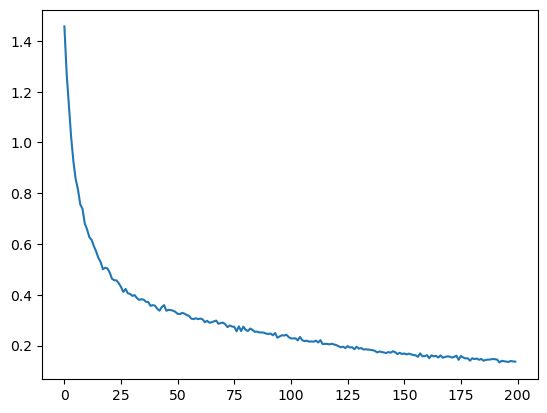

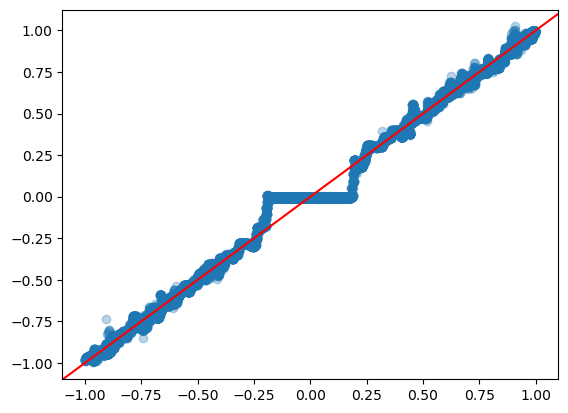

In [36]:
net = PolicyNetRSNNPB(**params)
for n, l in net.basis.items():
    torch.nn.init.kaiming_normal_(l.input_con.weight)
opt = torch.optim.Adam(net.parameters())
print(net)

losses = []
for i in range(200):
    x = torch.tanh(torch.randn((T, N, 1)))
    net.reset_state()
    mu, logvar = net(x, x)
    y = mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)
    loss = torch.nn.functional.mse_loss(y[warmup:], x[warmup:])
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 30.)
    opt.step()
    losses.append(loss.item())
    if i % 10 == 0:
        print(i, losses[-1])
        #print(net.basis['mu'].V_tau.data.mean())
        #print(net.basis['lif_ff1'].V_tau.data.mean())
plt.plot(losses)
plt.show()
plt.scatter(x, mu.detach(), alpha=0.3)
plt.axline((1, 1), slope=1, c='red')
plt.show()

In [ ]:
plt.plot(losses)
plt.yscale('log')
plt.show()
y = mu.detach() + torch.exp(0.5 * logvar.detach()) * torch.randn_like(mu)
plt.scatter(x, y, alpha=0.3)
plt.axline((1, 1), slope=1, c='red')
plt.show()

In [ ]:
x = torch.tanh(torch.randn((5, 1, 1)))
net.reset_state()
mu, logvar = net(x, x)
y = mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)

In [ ]:
V_tau = torch.tensor(10e-3)
dt = 0.004
alpha = torch.exp(-dt / V_tau)

In [ ]:
alpha

In [ ]:
Vtc = -dt / torch.log(alpha)
Vtc

In [61]:
import copy
import snntorch as snn
from snntorch.functional import probe

class PolicyNetRSNNPB_snntorch(Module):
    def __init__(self, action_dim: int, state_dim: int, target_dim: int, hidden_dim: int, num_rec_layers: int = 0,
                 num_ff_layers: int = 1, repeat_input: int = 1, out_style: str = 'mean',
                 dt: float = 1e-3, device=None, dtype=None, flif_kwargs: dict = {}, readout_kwargs: dict = {},
                 **kwargs) -> None:

        factory_kwargs = {'device': device, 'dtype': dtype}
        super(PolicyNetRSNNPB_snntorch, self).__init__()
        self.action_dim = action_dim
        n_pop = 10

        # gather layer parameters
        rec_flif_kwargs = copy.deepcopy(flif_kwargs)
        rec_flif_kwargs['recurrent'] = True
        ff_flif_kwargs = copy.deepcopy(flif_kwargs)
        ff_flif_kwargs['recurrent'] = False
        in_dim = state_dim + target_dim
        self.dt = dt
        V_tau_lif = torch.tensor(flif_kwargs.get('V_tau_mean', 10e-3))
        I_tau_lif = torch.tensor(flif_kwargs.get('I_tau_mean', 5e-3))
        alpha_lif = torch.exp(-self.dt / I_tau_lif)
        beta_lif = torch.exp(-self.dt / V_tau_lif)
        V_tau_out = torch.tensor(readout_kwargs.get('V_tau_mean', 10e-3))
        I_tau_out = torch.tensor(readout_kwargs.get('I_tau_mean', 5e-3))
        alpha_out = torch.exp(-self.dt / I_tau_out)
        beta_out = torch.exp(-self.dt / V_tau_out)

        # make layers
        layers = OrderedDict()
        for i in range(num_rec_layers):
            dim = in_dim if i == 0 else hidden_dim
            layers[f'lif_rec_in{i + 1}'] = nn.Linear(dim, hidden_dim, flif_kwargs.get('bias', True), **factory_kwargs)
            layers[f'lif_rec{i + 1}'] = snn.RSynaptic(
                #alpha=alpha_lif,
                alpha=torch.rand(hidden_dim),
                #beta=beta_lif.repeat(hidden_dim).clone(),
                beta=torch.rand(hidden_dim),
                linear_features=hidden_dim,
                #learn_alpha=flif_kwargs.get('train_I_tau', False),
                learn_beta=flif_kwargs.get('train_V_tau', False),
                init_hidden=True
            )
            #layers[f'lif_rec{i + 1}'] = FLIF_B(dim, hidden_dim, bias=bias, dt=dt, **factory_kwargs, **rec_flif_kwargs)
        for i in range(num_ff_layers):
            dim = in_dim if (i == 0 and num_rec_layers == 0) else hidden_dim
            layers[f'lif_ff_in{i + 1}'] = nn.Linear(dim, hidden_dim, flif_kwargs.get('bias', True), **factory_kwargs)
            layers[f'lif_ff{i + 1}'] = snn.Synaptic(
                #alpha=alpha_lif,
                alpha=torch.rand(hidden_dim),
                #beta=beta_lif.repeat(hidden_dim).clone(),
                beta=torch.rand(hidden_dim),
                #learn_alpha=flif_kwargs.get('train_I_tau', False),
                learn_beta=flif_kwargs.get('train_V_tau', False),
                init_hidden=True
            )
            #layers[f'lif_ff{i + 1}'] = FLIF_B(dim, hidden_dim, bias=bias, dt=dt, **factory_kwargs, **ff_flif_kwargs)
        layers['mu_in'] = nn.Linear(hidden_dim, n_pop*action_dim, readout_kwargs.get('bias', True), **factory_kwargs)
        layers['mu'] = snn.Synaptic(
            #alpha=alpha_out,
            alpha=0.,
            #beta=beta_out.repeat(n_pop*action_dim).clone(),
            beta=torch.rand(n_pop*action_dim),
            learn_alpha=readout_kwargs.get('train_I_tau', False),
            learn_beta=flif_kwargs.get('train_V_tau', False),
            reset_mechanism='none',
            output=True,
            init_hidden=True
        )
        layers['mu_out'] = nn.Linear(n_pop*action_dim, action_dim, bias=False)
        torch.nn.init.constant_(layers['mu_out'].weight, 1. / n_pop)
        layers['logvar_in'] = nn.Linear(hidden_dim, n_pop*action_dim, readout_kwargs.get('bias', True), **factory_kwargs)
        layers['logvar'] = snn.Synaptic(
            #alpha=alpha_out,
            alpha=0.,
            #beta=beta_out.repeat(n_pop*action_dim).clone(),
            beta=torch.rand(n_pop*action_dim),
            learn_alpha=readout_kwargs.get('train_I_tau', False),
            learn_beta=flif_kwargs.get('train_V_tau', False),
            reset_mechanism='none',
            output=True,
            init_hidden=True
        )
        layers['logvar_out'] = nn.Linear(n_pop*action_dim, action_dim, bias=False)
        torch.nn.init.constant_(layers['logvar_out'].weight, 1. / n_pop)

        #layers['mu'] = Readout(hidden_dim, action_dim, dt=dt, **factory_kwargs, **readout_kwargs)
        #layers['logvar'] = Readout(hidden_dim, action_dim, dt=dt, **factory_kwargs, **readout_kwargs)

        self.basis = nn.ModuleDict(layers)

        self.state_initialized = False
        assert repeat_input >= 1
        self.repeat_input = repeat_input
        assert out_style.lower() in ['mean', 'last']
        self.out_style = out_style.lower()

    def reset_state(self) -> None:
        self.state_initialized = False

    def init_state(self, batch_size: int = 1) -> None:
        for name, layer in self.basis.items():
            reset_fn = getattr(layer, 'reset_hidden', None)
            if callable(reset_fn): reset_fn()
        self.state_initialized = True

    def step(self, state: Tensor, target: Tensor) -> [Tensor, Tensor]:
        x = torch.cat((state, target), -1)
        for name, layer in self.basis.items():
            if 'lif' in name.lower():
                x = layer(x)

        mu = self.basis.mu_out(self.basis.mu(self.basis.mu_in(x))[-1])
        logvar = self.basis.logvar_out(self.basis.logvar(self.basis.logvar_in(x))[-1])

        return mu, logvar

    def forward(self, state: Tensor, target: Tensor) -> [Tensor, Tensor]:

        if len(state.shape) == 2:
            state.unsqueeze_(0)

        if len(target.shape) == 2:
            target.unsqueeze_(0)

        T = state.shape[0]
        N = state.shape[1]
        D = state.shape[2]

        if not self.state_initialized:
            self.init_state(N)

        mu_outs = torch.empty((T, N, self.action_dim), device=state.device)
        logvar_outs = torch.empty((T, N, self.action_dim), device=state.device)
        for t in range(T):
            mu, logvar = self.step(state[t], target[t])
            mu_outs[t] = mu
            logvar_outs[t] = logvar

        return mu_outs, logvar_outs

    def predict(self, state: Tensor, target: Tensor, deterministic: bool = False) -> Tensor:

        mu, logvar = self(state, target)

        if deterministic:
            return mu
        else:
            return rp(mu, logvar)

In [62]:
params = dict(
    action_dim=1,
    state_dim=1,
    target_dim=1,
    hidden_dim=256,
    num_rec_layers=0,
    num_ff_layers=2,
    dt=0.004,
    repeat_input=5,
    out_style='mean',
    flif_kwargs=dict(
        V_tau_mean=0.01,
        train_V_tau=True,
        train_I_tau=True,
        threshold_delta_max=0.0,
        bias=True
    ),
    readout_kwargs=dict(
        V_tau_mean=0.001,
        train_V_tau=True,
        train_I_tau=False,
        bias=True
    )
)
warmup = 8
T = 100
N = 256

In [63]:
def print_tau(net):
    for n, l in net.basis.items():
        print(n, l)
        try:
            print('beta', l.beta.data)
            #print('dt', net.dt)
            tau = -net.dt / torch.log(l.beta)
            print('tau', tau)
        except:
            pass

PolicyNetRSNNPB_snntorch(
  (basis): ModuleDict(
    (lif_ff_in1): Linear(in_features=2, out_features=256, bias=True)
    (lif_ff1): Synaptic()
    (lif_ff_in2): Linear(in_features=256, out_features=256, bias=True)
    (lif_ff2): Synaptic()
    (mu_in): Linear(in_features=256, out_features=10, bias=True)
    (mu): Synaptic()
    (mu_out): Linear(in_features=10, out_features=1, bias=False)
    (logvar_in): Linear(in_features=256, out_features=10, bias=True)
    (logvar): Synaptic()
    (logvar_out): Linear(in_features=10, out_features=1, bias=False)
  )
)
0 0.6419603824615479
10 0.4153080880641937
20 0.14764052629470825
30 0.0709524154663086
40 0.023129448294639587
50 0.01639130711555481
60 0.010733067989349365
70 0.008869757875800133
80 0.007400682661682367
90 0.006394034717231989
100 0.0057356092147529125
110 0.005299447104334831
120 0.005007187370210886
130 0.0046943174675107
140 0.004455525428056717
150 0.004180655814707279
160 0.003995665814727545
170 0.0037534141447395086
180 0.00

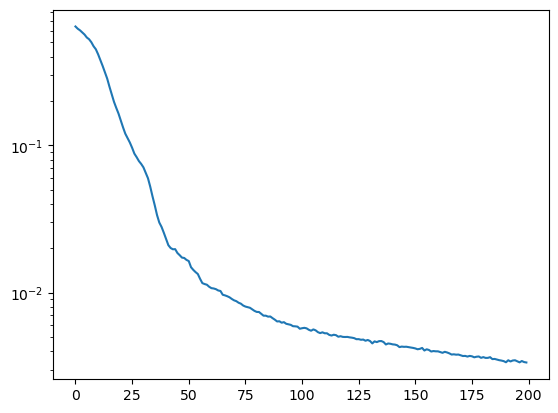

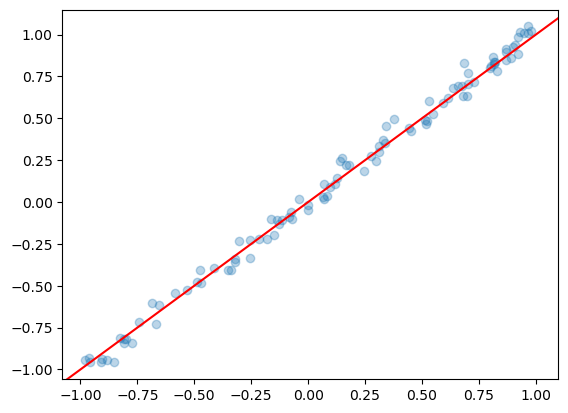

In [64]:
#device = 'cuda'
net = PolicyNetRSNNPB_snntorch(**params).to(device)
opt = torch.optim.Adam(net.parameters())
print(net)
ri = params['repeat_input']

losses = []
for i in range(200):
    x = torch.tanh(torch.randn((T, N, 1))).to(device)
    net.reset_state()
    ys = []
    for t in range(T):
        for j in range(ri):
            mu, logvar = net(x[t], x[t])
            y = mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)
            ys.append(y)
    y = torch.stack(ys, dim=0).squeeze(1)
    if params['out_style'].lower() == 'last':
        y = y[::ri]
    elif params['out_style'].lower() == 'mean':
        y = torch.nn.functional.avg_pool1d(y.transpose(0, 2), ri, ri).transpose(0, 2)
    loss = torch.nn.functional.mse_loss(y[warmup:], x[warmup:])
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 30.)
    opt.step()
    losses.append(loss.item())
    if i % 10 == 0:
        print(i, losses[-1])

plt.plot(losses)
plt.yscale('log')
plt.show()

x = torch.tanh(torch.randn((T, 1, 1), device=device))
net.reset_state()
ys = []
for t in range(T):
    for j in range(ri):
        mu, logvar = net(x[t], x[t])
        y = mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)
        ys.append(y)
y = torch.stack(ys, dim=0).squeeze(1)
if params['out_style'].lower() == 'last':
    y = y[::ri]
elif params['out_style'].lower() == 'mean':
    y = torch.nn.functional.avg_pool1d(y.transpose(0, 2), ri, ri).transpose(0, 2)

plt.scatter(x.cpu(), y.detach().cpu(), alpha=0.3)
plt.axline((1, 1), slope=1, c='red')
plt.show()

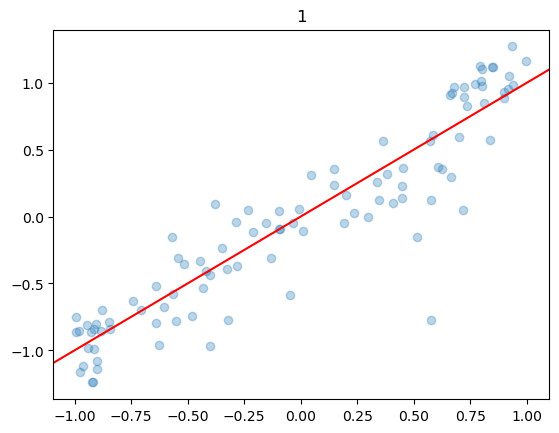

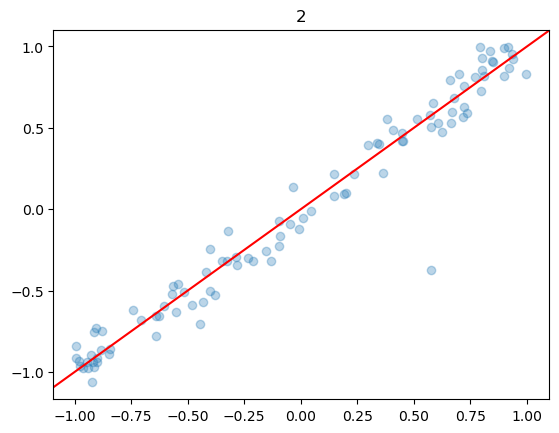

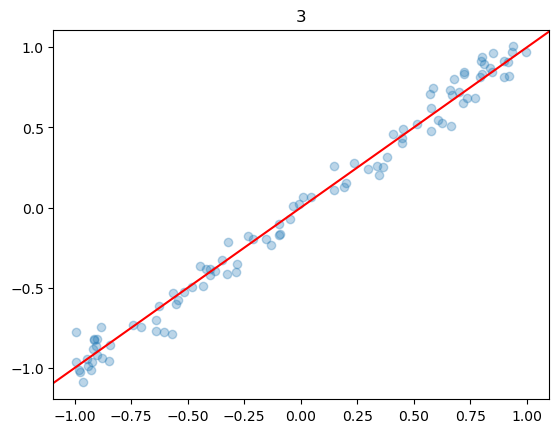

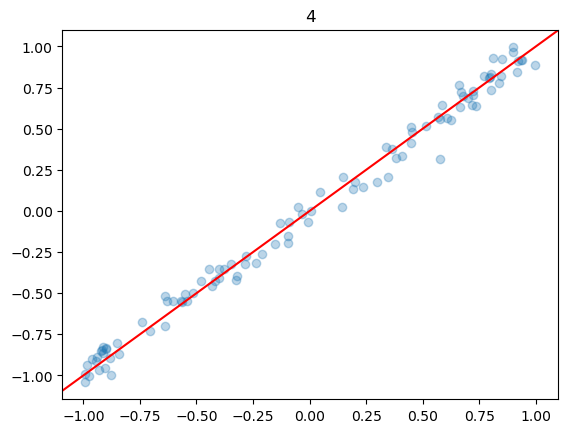

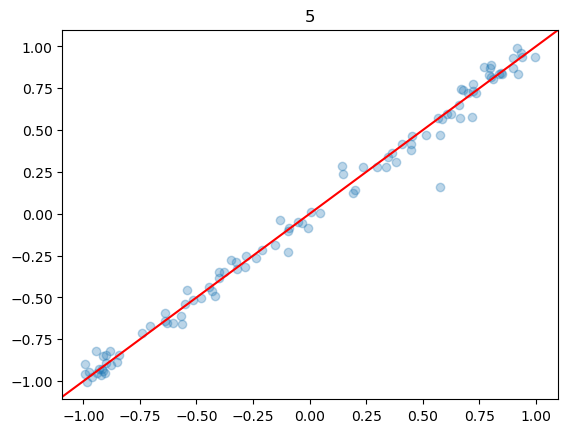

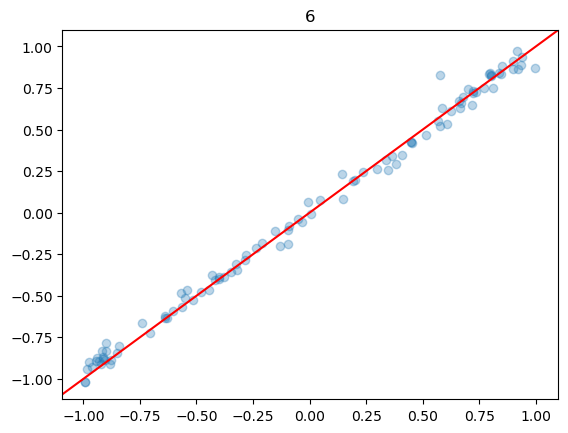

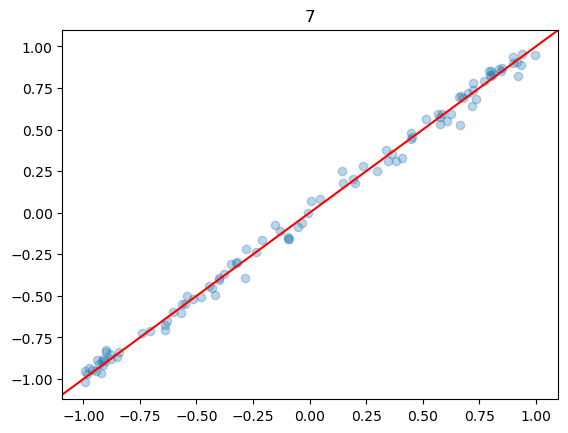

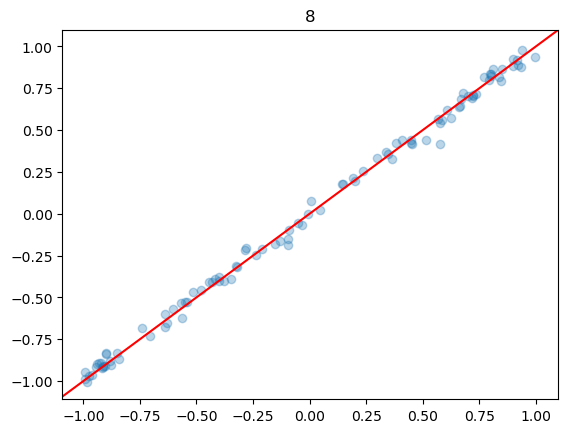

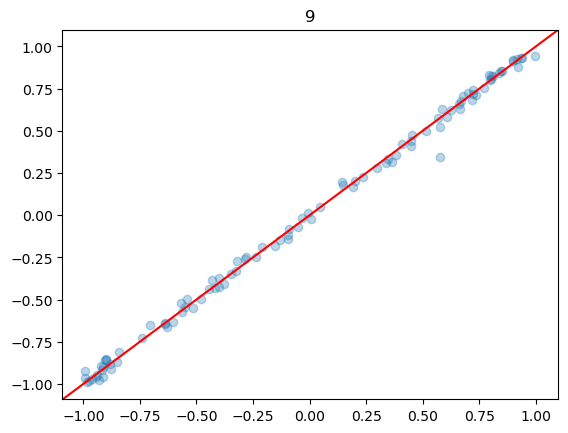

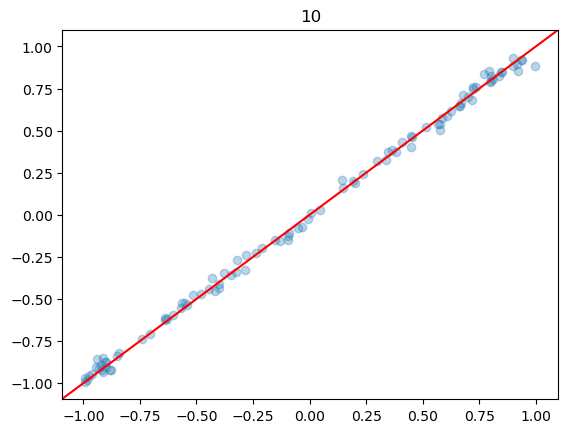

In [87]:
x = torch.tanh(torch.randn((T, 1, 1), device=device))

for ri in range(1, 11):
    net.reset_state()
    ys = []
    for t in range(T):
        for j in range(ri):
            mu, logvar = net(x[t], x[t])
            y = mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)
            ys.append(y)
    y = torch.stack(ys, dim=0).squeeze(1)
    y_ = y[::ri].detach().cpu()
    y_ = torch.nn.functional.avg_pool1d(y.transpose(0, 2), ri, ri).transpose(0, 2).detach().cpu()

    plt.scatter(x.cpu(), y_, alpha=0.3)
    plt.axline((1, 1), slope=1, c='red')
    plt.title(ri)
    plt.show()

In [ ]:
for n, l in net.basis.items():
    print(n, l)
    try:
        print('beta', l.beta.data)
        print('dt', net.dt)
        tau = -net.dt / torch.log(l.beta)
        print('tau', tau)
    except:
        pass

print()

print_tau(net)

In [ ]:
class PolicyNetRSNNPB_nonspike(Module):
    def __init__(self, action_dim: int, state_dim: int, target_dim: int, hidden_dim: int, num_rec_layers: int = 0,
                 num_ff_layers: int = 1, repeat_input: int = 1, out_style: str = 'mean',
                 dt: float = 1e-3, device=None, dtype=None, flif_kwargs: dict = {}, readout_kwargs: dict = {},
                 **kwargs) -> None:

        factory_kwargs = {'device': device, 'dtype': dtype}
        super(PolicyNetRSNNPB_nonspike, self).__init__()
        self.action_dim = action_dim

        # gather layer parameters
        rec_flif_kwargs = copy.deepcopy(flif_kwargs)
        rec_flif_kwargs['recurrent'] = True
        ff_flif_kwargs = copy.deepcopy(flif_kwargs)
        ff_flif_kwargs['recurrent'] = False
        in_dim = state_dim + target_dim
        self.dt = dt
        V_tau_lif = torch.tensor(flif_kwargs.get('V_tau_mean', 10e-3))
        I_tau_lif = torch.tensor(flif_kwargs.get('I_tau_mean', 5e-3))
        alpha_lif = torch.exp(-self.dt / I_tau_lif)
        beta_lif = torch.exp(-self.dt / V_tau_lif)
        V_tau_out = torch.tensor(readout_kwargs.get('V_tau_mean', 10e-3))
        I_tau_out = torch.tensor(readout_kwargs.get('I_tau_mean', 5e-3))
        alpha_out = torch.exp(-self.dt / I_tau_out)
        beta_out = torch.exp(-self.dt / V_tau_out)

        # make layers
        layers = OrderedDict()
        for i in range(num_rec_layers):
            dim = in_dim if i == 0 else hidden_dim
            layers[f'lif_rec_in{i + 1}'] = nn.Linear(dim, hidden_dim, flif_kwargs.get('bias', True), **factory_kwargs)
            layers[f'lif_rec{i + 1}'] = nn.LeakyReLU()
            #layers[f'lif_rec{i + 1}'] = FLIF_B(dim, hidden_dim, bias=bias, dt=dt, **factory_kwargs, **rec_flif_kwargs)
        for i in range(num_ff_layers):
            dim = in_dim if (i == 0 and num_rec_layers == 0) else hidden_dim
            layers[f'lif_ff_in{i + 1}'] = nn.Linear(dim, hidden_dim, flif_kwargs.get('bias', True), **factory_kwargs)
            layers[f'lif_ff{i + 1}'] = nn.LeakyReLU()
            #layers[f'lif_ff{i + 1}'] = FLIF_B(dim, hidden_dim, bias=bias, dt=dt, **factory_kwargs, **ff_flif_kwargs)
        layers['mu'] = nn.Linear(hidden_dim, action_dim, readout_kwargs.get('bias', True), **factory_kwargs)
        layers['logvar'] = nn.Linear(hidden_dim, action_dim, readout_kwargs.get('bias', True), **factory_kwargs)

        #layers['mu'] = Readout(hidden_dim, action_dim, dt=dt, **factory_kwargs, **readout_kwargs)
        #layers['logvar'] = Readout(hidden_dim, action_dim, dt=dt, **factory_kwargs, **readout_kwargs)

        self.basis = nn.ModuleDict(layers)

        self.state_initialized = False
        assert repeat_input >= 1
        self.repeat_input = repeat_input
        assert out_style.lower() in ['mean', 'last']
        self.out_style = out_style.lower()

    def reset_state(self) -> None:
        self.state_initialized = False

    def init_state(self, batch_size: int = 1) -> None:
        for name, layer in self.basis.items():
            try:
                layer.reset_hidden()
            except:
                pass
        self.state_initialized = True

    def step(self, state: Tensor, target: Tensor) -> [Tensor, Tensor]:
        x = torch.cat((state, target), -1)
        for name, layer in self.basis.items():
            if 'lif' in name.lower():
                x = layer(x)

        mu = self.basis.mu(x)
        logvar = self.basis.logvar(x)

        return mu, logvar

    def forward(self, state: Tensor, target: Tensor) -> [Tensor, Tensor]:

        if len(state.shape) == 2:
            state.unsqueeze_(0)

        if len(target.shape) == 2:
            target.unsqueeze_(0)

        T = state.shape[0]
        N = state.shape[1]
        D = state.shape[2]

        if not self.state_initialized:
            self.init_state(N)

        mu_outs = torch.empty((T, N, self.action_dim), device=next(self.basis.mu.parameters()).device)
        logvar_outs = torch.empty((T, N, self.action_dim), device=next(self.basis.logvar.parameters()).device)
        for t in range(T):
            mus, logvars = [], []
            for i in range(self.repeat_input):
                mu, logvar = self.step(state[t], target[t])
                mus.append(mu)
                logvars.append(logvar)
            if self.out_style == 'last':
                mu_outs[t] = mu
                logvar_outs[t] = logvar
            elif self.out_style == 'mean':
                mus = torch.stack(mus)
                logvars = torch.stack(logvars)
                mu_outs[t] = mus.mean(dim=0)
                logvar_outs[t] = logvars.mean(dim=0)

        return mu_outs, logvar_outs

    def predict(self, state: Tensor, target: Tensor, deterministic: bool = False) -> Tensor:

        mu, logvar = self(state, target)

        if deterministic:
            return mu
        else:
            return rp(mu, logvar)

In [ ]:
params = dict(
    action_dim=1,
    state_dim=1,
    target_dim=1,
    hidden_dim=256,
    num_rec_layers=0,
    num_ff_layers=2,
    dt=0.004,
    repeat_input=5,
    out_style='last',
    flif_kwargs=dict(
        V_tau_mean=0.001,
        train_V_tau=True,
        train_I_tau=True,
        threshold_delta_max=0.0,
        bias=True
    ),
    readout_kwargs=dict(
        V_tau_mean=0.001,
        train_V_tau=True,
        train_I_tau=True,
        bias=True
    )
)
warmup = 8
T = 100
N = 256

In [ ]:
net = PolicyNetRSNNPB_nonspike(**params)
opt = torch.optim.Adam(net.parameters())
print(net)

losses = []
for i in range(200):
    x = torch.tanh(torch.randn((T, N, 1)))
    net.reset_state()
    mu, logvar = net(x, x)
    y = mu + torch.exp(0.5 * logvar) * torch.randn_like(mu)
    loss = torch.nn.functional.mse_loss(y[warmup:], x[warmup:])
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 30.)
    opt.step()
    losses.append(loss.item())
    if i % 10 == 0:
        print(i, losses[-1])
        print_tau(net)
        #print(net.basis['mu'].V_tau.data.mean())
        #print(net.basis['lif_ff1'].V_tau.data.mean())
plt.plot(losses)
plt.show()
plt.scatter(x, mu.detach(), alpha=0.3)
plt.axline((1, 1), slope=1, c='red')
plt.show()

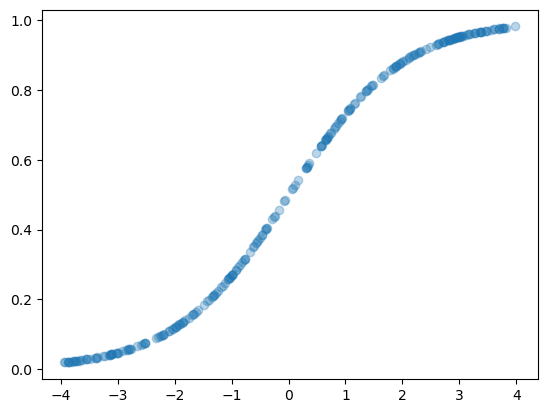

In [48]:
#b = torch.randn(1000)
b = torch.FloatTensor(256).uniform_(-4., 4.)
bet = torch.sigmoid(b)
plt.scatter(b, bet, alpha=0.3)

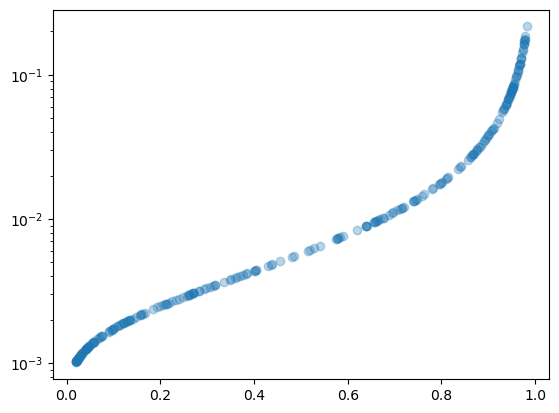

In [51]:
tc = - 0.004 / torch.log(bet)
plt.scatter(bet, tc, alpha=0.3)
plt.yscale('log')

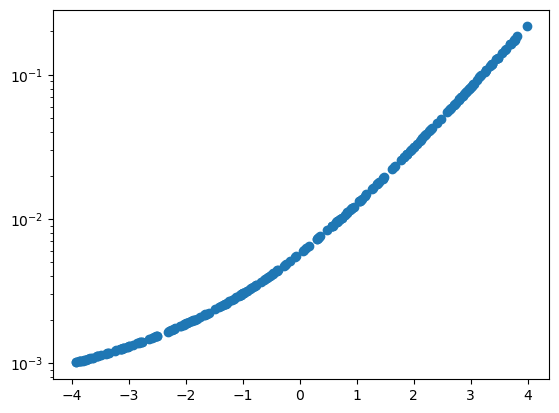

In [52]:
plt.scatter(b, tc)
plt.yscale('log')

In [39]:
d = 0.004
t = torch.tensor(0.1)
b = torch.exp(-d / t)
b

tensor(0.9608)

In [41]:
tc = -d / torch.log(b)
tc

In [7]:
params = dict(
    action_dim=1,
    state_dim=1,
    target_dim=1,
    hidden_dim=256,
    num_rec_layers=0,
    num_ff_layers=2,
    dt=0.004,
    repeat_input=5,
    out_style='mean',
    flif_kwargs=dict(
        V_tau_mean=0.01,
        train_V_tau=True,
        train_I_tau=True,
        threshold_delta_max=0.0,
        bias=True
    ),
    readout_kwargs=dict(
        V_tau_mean=0.001,
        train_V_tau=True,
        train_I_tau=False,
        bias=True
    )
)
warmup = 8
T = 100
N = 256

In [8]:
class PolicyNetRSNNPB_snntorch(Module):
    def __init__(self, action_dim: int, state_dim: int, target_dim: int, hidden_dim: int, num_rec_layers: int = 0,
                 num_ff_layers: int = 1, repeat_input: int = 1, out_style: str = 'mean',
                 dt: float = 1e-3, device=None, dtype=None, flif_kwargs: dict = {}, readout_kwargs: dict = {},
                 **kwargs) -> None:

        factory_kwargs = {'device': device, 'dtype': dtype}
        super(PolicyNetRSNNPB_snntorch, self).__init__()

        # gather layer parameters
        self.action_dim = action_dim
        self.repeat_input = repeat_input
        rec_flif_kwargs = copy.deepcopy(flif_kwargs)
        rec_flif_kwargs['recurrent'] = True
        ff_flif_kwargs = copy.deepcopy(flif_kwargs)
        ff_flif_kwargs['recurrent'] = False
        in_dim = state_dim + target_dim
        self.dt = dt
        #V_tau_lif = torch.tensor(flif_kwargs.get('V_tau_mean', torch.rand(hidden_dim)))
        #I_tau_lif = torch.tensor(flif_kwargs.get('I_tau_mean', torch.rand(hidden_dim)))
        #alpha_lif = torch.exp(-self.dt / I_tau_lif)
        #beta_lif = torch.exp(-self.dt / V_tau_lif)
        #V_tau_out = torch.tensor(readout_kwargs.get('V_tau_mean', torch.rand(action_dim)))
        #I_tau_out = torch.tensor(readout_kwargs.get('I_tau_mean', torch.rand(action_dim)))
        #alpha_out = torch.exp(-self.dt / I_tau_out)
        #beta_out = torch.exp(-self.dt / V_tau_out)
        n_pop = readout_kwargs.get('n_pop', 1)

        # make layers
        layers = OrderedDict()
        for i in range(num_rec_layers):
            dim = in_dim if i == 0 else hidden_dim
            layers[f'lif_rec_in{i + 1}'] = nn.Linear(dim, hidden_dim, flif_kwargs.get('bias', True), **factory_kwargs)
            layers[f'lif_rec{i + 1}'] = snn.RSynaptic(
                # alpha=alpha_lif,
                alpha=torch.rand(hidden_dim),
                # beta=beta_lif.repeat(hidden_dim).clone(),
                beta=torch.rand(hidden_dim),
                linear_features=hidden_dim,
                learn_alpha=flif_kwargs.get('train_I_tau', False),
                learn_beta=flif_kwargs.get('train_V_tau', False),
                init_hidden=True
            )
        for i in range(num_ff_layers):
            dim = in_dim if (i == 0 and num_rec_layers == 0) else hidden_dim
            layers[f'lif_ff_in{i + 1}'] = nn.Linear(dim, hidden_dim, flif_kwargs.get('bias', True), **factory_kwargs)
            layers[f'lif_ff{i + 1}'] = snn.Synaptic(
                # alpha=alpha_lif,
                alpha=torch.rand(hidden_dim),
                # beta=beta_lif.repeat(hidden_dim).clone(),
                beta=torch.rand(hidden_dim),
                learn_alpha=flif_kwargs.get('train_I_tau', False),
                learn_beta=flif_kwargs.get('train_V_tau', False),
                init_hidden=True
            )
        layers['mu_in'] = nn.Linear(hidden_dim, action_dim * n_pop, readout_kwargs.get('bias', True), **factory_kwargs)
        layers['mu'] = snn.Synaptic(
            # alpha=alpha_out,
            alpha=0.,
            # beta=beta_out.repeat(action_dim).clone(),
            beta=torch.rand(action_dim * n_pop),
            learn_alpha=readout_kwargs.get('train_I_tau', False),
            learn_beta=flif_kwargs.get('train_V_tau', False),
            reset_mechanism='none',
            output=True,
            init_hidden=True
        )
        layers['mu_out'] = nn.Linear(action_dim * n_pop, action_dim, bias=False)
        nn.init.constant_(layers['mu_out'].weight, 1. / n_pop)
        layers['logvar_in'] = nn.Linear(hidden_dim, action_dim * n_pop, readout_kwargs.get('bias', True), **factory_kwargs)
        layers['logvar'] = snn.Synaptic(
            #alpha=alpha_out,
            alpha=0.,
            #beta=beta_out.repeat(action_dim).clone(),
            beta=torch.rand(action_dim * n_pop),
            learn_alpha=readout_kwargs.get('train_I_tau', False),
            learn_beta=flif_kwargs.get('train_V_tau', False),
            reset_mechanism='none',
            output=True,
            init_hidden=True
        )
        layers['logvar_out'] = nn.Linear(action_dim * n_pop, action_dim, bias=False)
        nn.init.constant_(layers['logvar_out'].weight, 1. / n_pop)
        self.basis = nn.ModuleDict(layers)

        self.state_initialized = False
        assert repeat_input >= 1
        self.repeat_input = repeat_input
        assert out_style.lower() in ['mean', 'last']
        self.out_style = out_style.lower()

    def reset_state(self) -> None:
        self.state_initialized = False

    def init_state(self, batch_size: int = 1) -> None:
        for name, layer in self.basis.items():
            reset_fn = getattr(layer, 'reset_hidden', None)
            if callable(reset_fn): reset_fn()
        self.state_initialized = True

    def step(self, state: Tensor, target: Tensor) -> [Tensor, Tensor]:
        x = torch.cat((state, target), -1)
        for name, layer in self.basis.items():
            if 'lif' in name.lower():
                x = layer(x)

        mu = self.basis.mu(self.basis.mu_in(x))[-1]
        logvar = self.basis.logvar(self.basis.logvar_in(x))[-1]

        return self.basis.mu_out(mu), self.basis.logvar_out(logvar)

    def forward(self, state: Tensor, target: Tensor) -> [Tensor, Tensor]:

        device = next(self.basis.mu.parameters()).device

        if len(state.shape) == 2:
            state.unsqueeze_(0)

        if len(target.shape) == 2:
            target.unsqueeze_(0)

        T = state.shape[0]
        N = state.shape[1]
        D = state.shape[2]

        if not self.state_initialized:
            self.init_state(N)

        mu_outs = torch.empty((T, N, self.action_dim), device=device)
        logvar_outs = torch.empty((T, N, self.action_dim), device=device)
        for t in range(T):
            mus, logvars = [], []
            for i in range(self.repeat_input):
                mu, logvar = self.step(state[t], target[t])
                mus.append(mu)
                logvars.append(logvar)
            if self.out_style == 'last':
                mu_outs[t] = mu
                logvar_outs[t] = logvar
            elif self.out_style == 'mean':
                mus = torch.stack(mus)
                logvars = torch.stack(logvars)
                mu_outs[t] = mus.mean(dim=0)
                logvar_outs[t] = logvars.mean(dim=0)

        return mu_outs, logvar_outs

    def predict(self, state: Tensor, target: Tensor, deterministic: bool = False) -> Tensor:

        mu, logvar = self(state, target)

        if deterministic:
            return mu
        else:
            return rp(mu, logvar)

In [9]:
policynet = PolicyNetRSNNPB_snntorch(**params)
print(policynet)

PolicyNetRSNNPB_snntorch(
  (basis): ModuleDict(
    (lif_ff_in1): Linear(in_features=2, out_features=256, bias=True)
    (lif_ff1): Synaptic()
    (lif_ff_in2): Linear(in_features=256, out_features=256, bias=True)
    (lif_ff2): Synaptic()
    (mu_in): Linear(in_features=256, out_features=1, bias=True)
    (mu): Synaptic()
    (mu_out): Linear(in_features=1, out_features=1, bias=False)
    (logvar_in): Linear(in_features=256, out_features=1, bias=True)
    (logvar): Synaptic()
    (logvar_out): Linear(in_features=1, out_features=1, bias=False)
  )
)
